In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
positive_class_path = 'malaria/uab curated/1'
negative_class_path = 'malaria/uab curated/0'
positive_class_path2 = 'malaria/uah/1/'
negative_class_path2 = 'malaria/uah/1/'


### Step 1 : Data Extraction / Preprocessing
Combining the data sources to create a singular data source

In [7]:
def file_append(class_path):    
    image_array = []    
    curr_path = os.path.join(os.getcwd(),class_path)
    cnt = 0
    file_list = [k for k in os.listdir(curr_path) if '.png' in k]
    for x in file_list:
        
        img_path = os.path.join(curr_path,x)

        img = imread(img_path)
#         img = rgb2gray(img)
        img = resize(img,(60,60,3))     ## Will need to change this resize parameter
        img = img.flatten()
        image_array.append(img)
        
    return image_array
    

pos_imgs_curated = file_append(positive_class_path)
pos_imgs_uah = file_append(positive_class_path2)

positive_df_curated  = pd.DataFrame(pos_imgs_curated)
positive_df_uah = pd.DataFrame(pos_imgs_uah)
positive_df = pd.concat([positive_df_curated,positive_df_uah],ignore_index=True)
positive_df['y'] = 1

neg_imgs_curated = file_append(negative_class_path)
neg_df_cur  = pd.DataFrame(neg_imgs_curated)
neg_imgs_uah = file_append(negative_class_path2)
neg_df_uah  = pd.DataFrame(neg_imgs_uah)
neg_df = pd.concat([neg_df_cur,neg_df_uah],ignore_index=True)
neg_df['y'] = 0

# plt.imshow(np.reshape(pos_imgs[2],(40,40,3)))
df = pd.concat([positive_df,neg_df,],ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


### Step 2 : Standardizing the data

### Step 2: Splitting entire dataset into train and test sets

In [12]:
X,y = df[df.columns[:-1]],df['y']
X = X/255
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=121)



### Dimensionality reduction

In [168]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(X_train)
exp_var = pca.explained_variance_ratio_

In [26]:
pca_data.shape[1]

319

In [27]:
PC_labels = ['PC_'+ str(x) for x in range(1,pca_data.shape[1])]

0.9500136779418267

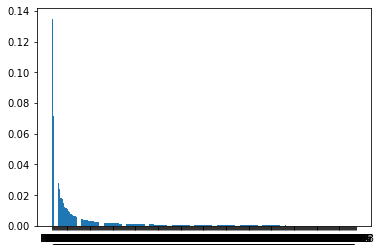

In [28]:
plt.bar(PC_labels,exp_var[:pca_data.shape[1]-1])
sum(exp_var[:pca_data.shape[1]])

In [29]:
pca_data.shape

(2915, 319)

## SVM Modelling

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [33]:
X_test_new = pca.transform(X_test)
model = SVC(C=1,kernel='rbf')


In [34]:
model.fit(pca_data,y_train)
print(f"Train score: {model.score(pca_data,y_train)}")
print(f"Test score : {accuracy_score(y_test,model.predict(X_test_new))}")


Train score: 0.8085763293310463
Test score : 0.7032


## SVM modelling with grid search CV

In [35]:
# parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.01,0.1,0.5,1]}
# grid_svc = SVC()
# clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)


parameters = {'kernel':['poly','rbf'], 'C':[0.01,0.05, 0.1,0.5,1,10]}
grid_svc = SVC()
clf = GridSearchCV(grid_svc, parameters,verbose=2,n_jobs=-1)



In [36]:
clf.fit(pca_data, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10],
                         'kernel': ['poly', 'rbf']},
             verbose=2)

In [61]:
clf.best_params_

{'C': 1, 'kernel': 'rbf'}

### K fold cross validation

In [46]:
X,y = df[df.columns[:-1]],df['y']
X = X/255

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=121)

In [48]:
pca = PCA(n_components=0.90)
pca_data = pca.fit_transform(X_train)

exp_var = pca.explained_variance_ratio_

In [49]:
print(pca_data.shape)
print(y.shape)

(2915, 153)
(4165,)


In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(SVC(C=1.5))
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=pca_data, y=y_train, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


Cross Validation accuracy scores: [0.71575342 0.70547945 0.73972603 0.73972603 0.72260274 0.75945017
 0.74226804 0.67697595 0.71134021 0.71821306]
Cross Validation accuracy: 0.723 +/- 0.022


In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(SVC(C=2))
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=pca_data, y=y_train, cv=10, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


Cross Validation accuracy scores: [0.70890411 0.69863014 0.72945205 0.73630137 0.70890411 0.73883162
 0.73195876 0.68041237 0.71477663 0.71821306]
Cross Validation accuracy: 0.717 +/- 0.017
